In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.eegnet import EEGNet
from src.dataloading import DataLoader
from src.preprocessing import Preprocesser

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

2024-01-13 13:33:36.455399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Data

In [3]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

CONDITIONS = ["MathxEasy", "MathxMedium", "MathxHard"]
pp_data = {}

for i, condition in enumerate(CONDITIONS):
    preprocessor = Preprocesser(df_list=df_list, condition=condition, partition_size=250, fixed_size=11000)
    tensor: np.array = preprocessor.preprocess_data()
    FEATURE_NAMES = list(preprocessor.df_list_processed[0].columns)

    pp_data[condition] = {
        "tensor": tensor,
        "y_list": preprocessor.y_list_processed,
        "condition": condition,
        "condition_encoded": i,
        "condition_df": pd.DataFrame([condition for n in range(0, tensor.shape[0])]),
        "condition_encoded_df": pd.DataFrame([i for n in range(0, tensor.shape[0])]),
        "feature_names": FEATURE_NAMES,
        "scaler_object": preprocessor.scaler
    }

# Stack data of each condition to one single 3D numpy array (input data to model)
tensor = np.concatenate([pp_data[key]["tensor"] for key in pp_data.keys()], axis=0)
y_tensor = np.concatenate([pp_data[key]["y_list"] for key in pp_data.keys()], axis=0)
conditions = pd.concat(pp_data[key]["condition_df"] for key in pp_data.keys())

# Get Labels in Shape (1290 x 1), i.e. (Number of Samples, Dimension_Label)
y_label_list = []
for i in range(0, y_tensor.shape[0]):
    y = y_tensor[i][0]
    y_label_list.append(y)
y_label = np.array(y_label_list)

# Discretize labels
def _discretize_target(val: float) -> np.array:
    """ Call this function via np.vectorize(_discretize_target)(y_label) """
    if val < 0.1:
        return 0
    elif 0.1 <= val < 0.3:
        return 1
    else:
        return 2

classes = np.vectorize(_discretize_target)(y_label)


2024-01-13 13:33:40,456 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2024-01-13 13:33:49,312 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


In [4]:
print(f"Shape of Input Data: {tensor.shape}")
print(f"Shape of condition_df: {conditions.shape}")
print(f"Shape of Labels: {y_tensor.shape}")

2024-01-13 13:33:49,423 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxEasy, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 13:33:49,597 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 13:33:49,609 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.19s) ...

2024-01-13 13:33:49,612 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxMedium, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 13:33:49,766 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 13:33:49,778 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.16s) ...

2024-01-13 13:33:49,780 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Partition Size: 250, Fixed Size: 11000) ...
2024-01-13 13:33:49,952 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-13 13:33:49,965 - src.preprocessing - INFO - Finished preprocessin

## Discretize labels

In [ ]:
import seaborn as sns
sns.histplot(y_label.flatten())

In [6]:
from tensorflow.keras.utils import to_categorical
classes = to_categorical(classes)
classes.shape

# EEGNet

In [8]:
clf = EEGNet(nb_classes=3, Chans=7, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 250, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 7, 250, 8)         1024      
                                                                 
 batch_normalization (Batch  (None, 7, 250, 8)         32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 250, 16)        112       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 250, 16)        64        
 chNormalization)                                                
                                                             

In [9]:
clf.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Epoch 1/64
297/297 - 5s - loss: 0.9626 - accuracy: 0.5345 - val_loss: 0.9056 - val_accuracy: 0.6667 - 5s/epoch - 18ms/step
Epoch 2/64
297/297 - 4s - loss: 0.8571 - accuracy: 0.5976 - val_loss: 2.5016 - val_accuracy: 0.0000e+00 - 4s/epoch - 12ms/step
Epoch 3/64
297/297 - 4s - loss: 0.7735 - accuracy: 0.6608 - val_loss: 1.2535 - val_accuracy: 0.3333 - 4s/epoch - 12ms/step
Epoch 4/64
297/297 - 4s - loss: 0.7678 - accuracy: 0.6566 - val_loss: 1.9917 - val_accuracy: 0.0000e+00 - 4s/epoch - 12ms/step
Epoch 5/64
297/297 - 3s - loss: 0.7228 - accuracy: 0.6852 - val_loss: 1.4364 - val_accuracy: 0.3258 - 3s/epoch - 11ms/step
Epoch 6/64
297/297 - 3s - loss: 0.7083 - accuracy: 0.6843 - val_loss: 1.0015 - val_accuracy: 0.5758 - 3s/epoch - 11ms/step
Epoch 7/64
297/297 - 3s - loss: 0.6614 - accuracy: 0.7096 - val_loss: 2.2375 - val_accuracy: 0.0000e+00 - 3s/epoch - 11ms/step
Epoch 8/64
297/297 - 3s - loss: 0.6516 - accuracy: 0.7071 - val_loss: 1.6091 - val_accuracy: 0.3333 - 3s/epoch - 11ms/step
Epoc

In [10]:
clf.summary()

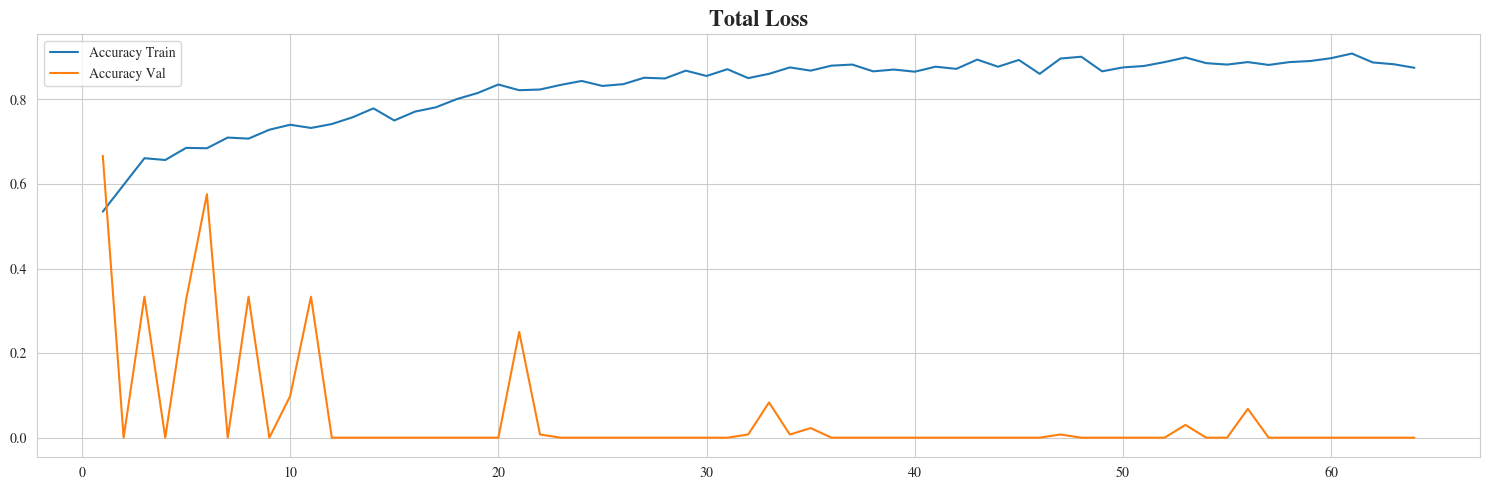

In [11]:
history = clf.fit(tensor.transpose(0, 2, 1)[:, :, :, np.newaxis], classes, batch_size = 4, epochs = 32, verbose = 2, validation_split=0.2, shuffle=True)

In [ ]:
def _plot_history_acc(history) -> None:
    acc_train = history.history["accuracy"]
    acc_val = history.history["val_accuracy"]
    x = [i+1 for i in range(0, len(acc_train))]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=acc_train, label="Accuracy Train", ax=ax)
    sns.lineplot(x=x, y=acc_val, label="Accuracy Val", ax=ax)
    fig.tight_layout()
    plt.show()

In [12]:
_plot_history_acc(history)

# EEGNet Conv1D

In [14]:
from src.eegnet import EEGNetConv1D

In [15]:
model = EEGNetConv1D(nb_classes=3, timesteps=250, channels=7, dropoutRate=0.5)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [16]:
model.summary()

In [16]:
history = model.fit(tensor, classes, batch_size = 4, epochs = 32, verbose = 2, validation_split=0.2, shuffle=True)

In [ ]:
_plot_history_acc(history)